In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_path = "fire_dataset"
fire_dir = os.path.join(dataset_path, "fire_images")
non_fire_dir = os.path.join(dataset_path, "non_fire_images")

# Create directories
os.makedirs(os.path.join(dataset_path, "train", "fire"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "train", "non_fire"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "validation", "fire"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "validation", "non_fire"), exist_ok=True)

# Split fire images into train/validation (40 for validation)
fire_images = os.listdir(fire_dir)
train_fire, val_fire = train_test_split(fire_images, test_size=40, random_state=42)
for img in train_fire:
    shutil.move(os.path.join(fire_dir, img), os.path.join(dataset_path, "train", "fire", img))
for img in val_fire:
    shutil.move(os.path.join(fire_dir, img), os.path.join(dataset_path, "validation", "fire", img))

# Split non-fire images into train/validation (40 for validation)
non_fire_images = os.listdir(non_fire_dir)
train_non_fire, val_non_fire = train_test_split(non_fire_images, test_size=40, random_state=42)
for img in train_non_fire:
    shutil.move(os.path.join(non_fire_dir, img), os.path.join(dataset_path, "train", "non_fire", img))
for img in val_non_fire:
    shutil.move(os.path.join(non_fire_dir, img), os.path.join(dataset_path, "validation", "non_fire", img))

In [3]:
import os
import numpy as np
from imgaug import augmenters as iaa
import imageio
from tqdm import tqdm

# Define the augmentation pipeline
augmentation = iaa.Sequential([
    # Rotation: randomly rotate images between -30 and 30 degrees
    iaa.Affine(rotate=(-30, 30)),
    # Flipping: horizontally flip 50% of images
    iaa.Fliplr(0.5),
    # Brightness adjustment: modify brightness between 0.8 and 1.2
    iaa.Multiply((0.8, 1.2))  # Use Multiply instead of MultiplyBrightness
])

# Source and destination paths
src_path = "fire_dataset/train/fire"
dest_path = "fire_dataset/train/fire"  # Adding augmented images to the original folder

# Create destination directory if it doesn't exist
os.makedirs(dest_path, exist_ok=True)

# Get list of original images
images = [f for f in os.listdir(src_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Number of augmented versions per image
num_augmentations = 3

print(f"Augmenting {len(images)} fire images...")
for img_name in tqdm(images):
    # Read image
    img_path = os.path.join(src_path, img_name)
    try:
        img = imageio.imread(img_path)
        
        # Convert 4-channel images to 3-channel RGB
        if img.shape[-1] == 4:
            img = img[:, :, :3]
        
        # Generate augmented versions
        for i in range(num_augmentations):
            try:
                # Apply augmentation
                augmented_img = augmentation(image=img)
                
                # Save augmented image
                base_name, ext = os.path.splitext(img_name)
                aug_name = f"{base_name}_aug{i+1}{ext}"
                aug_path = os.path.join(dest_path, aug_name)
                imageio.imwrite(aug_path, augmented_img)
            except Exception as e:
                print(f"Error augmenting {img_name} (version {i+1}): {str(e)}")
    except Exception as e:
        print(f"Error loading {img_name}: {str(e)}")

print(f"Augmentation complete! Added {len(images) * num_augmentations} new images.")


Augmenting 715 fire images...


  0%|          | 0/715 [00:00<?, ?it/s]C:\Users\nakul\AppData\Local\Temp\ipykernel_33344\3120970097.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
100%|██████████| 715/715 [05:28<00:00,  2.17it/s]

Augmentation complete! Added 2145 new images.


In [5]:
import os
import numpy as np
from imgaug import augmenters as iaa
import imageio
from tqdm import tqdm
import random
if not hasattr(np, 'complex'):
    np.complex = complex 
# Define fire-like effect augmentation sequence
fire_effect = iaa.Sequential([
    # Add reddish-orange tint
    iaa.AddToHueAndSaturation((-30, 10), per_channel=False),
    # Increase brightness in patches to simulate flames
    iaa.BlendAlphaSimplexNoise(
        foreground=iaa.Multiply((1.5, 2.2)),
        per_channel=True
    ),
    # Add some "flickering" effect
    iaa.BlendAlphaFrequencyNoise(
        exponent=(-2.5, -1.0),
        foreground=iaa.Multiply((1.5, 2.5)),
        size_px_max=(16, 32),
        per_channel=True
    ),
    # Add some blur to make it look more natural
    iaa.Sometimes(0.7, iaa.GaussianBlur(sigma=(0.5, 1.0)))
])

# Paths
src_path = "fire_dataset/train/non_fire"  # Source non-fire images
dest_path = "fire_dataset/train/non_fire"  # Save as non-fire (hard negatives)

# Create destination directory if it doesn't exist
os.makedirs(dest_path, exist_ok=True)

# Get list of original non-fire images
images = [f for f in os.listdir(src_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Number of synthetic images to generate
num_to_generate = max(100, len(images))  # Generate at least 100
num_per_image = max(1, int(num_to_generate / len(images)))

print(f"Generating {num_per_image} synthetic fire-like versions for each of {len(images)} non-fire images...")
synthetic_count = 0

for img_name in tqdm(images):
    # Read image
    img_path = os.path.join(src_path, img_name)
    try:
        img = imageio.imread(img_path)
        
        # Handle grayscale images
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=-1)
            
        # Handle RGBA images
        if img.shape[-1] == 4:
            img = img[:, :, :3]
        
        # Generate synthetic fire-like versions
        for i in range(num_per_image):
            try:
                # Apply fire-like effect
                augmented_img = fire_effect(image=img)
                
                # Save as non-fire image (hard negative)
                base_name, ext = os.path.splitext(img_name)
                aug_name = f"{base_name}_fakeFire{i+1}{ext}"
                aug_path = os.path.join(dest_path, aug_name)
                imageio.imwrite(aug_path, augmented_img)
                synthetic_count += 1
                
                # Stop if we've reached desired count
                if synthetic_count >= 100:
                    break
            except Exception as e:
                print(f"Error creating synthetic image for {img_name} (version {i+1}): {str(e)}")
    except Exception as e:
        print(f"Error loading {img_name}: {str(e)}")
    
    # Stop if we've generated enough
    if synthetic_count >= 100:
        break

print(f"Synthetic data creation complete! Added {synthetic_count} fire-like non-fire images.")


Generating 1 synthetic fire-like versions for each of 204 non-fire images...


  0%|          | 0/204 [00:00<?, ?it/s]C:\Users\nakul\AppData\Local\Temp\ipykernel_33344\3491933166.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
 49%|████▊     | 99/204 [01:00<01:04,  1.64it/s]

Synthetic data creation complete! Added 100 fire-like non-fire images.


Create flickered dataset

In [1]:
import os
import numpy as np
import cv2
from imgaug import augmenters as iaa
import imageio
from tqdm import tqdm

def create_flickered_dataset(dataset_path, output_path, img_size=(224, 224)):
    """
    Creates temporal flicker simulation by generating 3 slightly modified copies
    of each image and stacking them to form a 9-channel input.
    
    Args:
        dataset_path: Path to original fire_dataset directory
        output_path: Where to save the processed dataset
        img_size: Target dimensions for the images (height, width)
    """
    # Create output directories with the same structure
    for split in ["train", "validation"]:
        for class_name in ["fire", "non_fire"]:
            os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)
    
    # Define flicker simulation augmentation sequence
    # Uses controlled randomness to simulate temporal changes in flame appearance
    flicker_aug = iaa.Sequential([
        # Small rotation to simulate camera/flame movement
        iaa.Affine(rotate=(-5, 5)),
        # Add noise to simulate sensor variations and flame intensity changes
        iaa.AdditiveGaussianNoise(scale=(0.01*255, 0.03*255)),
        # Occasionally add slight blur to simulate motion
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        # Slight brightness variations to simulate flickering intensity
        iaa.Multiply((0.95, 1.05))
    ])
    
    # Process all images in the dataset
    for split in ["train", "validation"]:
        for class_name in ["fire", "non_fire"]:
            src_dir = os.path.join(dataset_path, split, class_name)
            dst_dir = os.path.join(output_path, split, class_name)
            
            # Get all images in the directory
            image_files = [f for f in os.listdir(src_dir) 
                          if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            
            print(f"Processing {len(image_files)} images in {src_dir}...")
            
            for img_file in tqdm(image_files):
                img_path = os.path.join(src_dir, img_file)
                try:
                    # Load and preprocess image
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read {img_path}, skipping...")
                        continue
                    
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Resize to target dimensions
                    img = cv2.resize(img, img_size)
                    
                    # Create 3 different versions to simulate temporal flicker
                    flickered_versions = []
                    for _ in range(3):
                        # Generate a slightly different version of the image
                        aug_img = flicker_aug(image=img)
                        flickered_versions.append(aug_img)
                    
                    # Stack the 3 versions (each with 3 RGB channels) to create a 9-channel input
                    stacked_img = np.concatenate(flickered_versions, axis=2)
                    
                    # Save the 9-channel stacked image
                    base_name, ext = os.path.splitext(img_file)
                    save_path = os.path.join(dst_dir, f"{base_name}_flickered.npy")
                    np.save(save_path, stacked_img)
                    
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    
    print("Flickering simulation complete!")


Model Implementation for 9-Channel Input

In [ ]:
# Execute the complete pipeline
if __name__ == "__main__":
    # 1. Create the flickered dataset
    create_flickered_dataset("fire_dataset", "fire_dataset_flickered")
    
    # 2. Load the dataset
    


Data Loading for 9-Channel Images

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model

def create_flickernet_model(input_shape=(224, 224, 9)):
    """
    Creates a MobileNetV2-based model that accepts 9-channel flickered images.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
                    where channels = 9 (3 RGB images stacked)
    
    Returns:
        Compiled Keras model
    """
    inputs = tf.keras.layers.Input(shape=(224, 224, 9))
    
    # Channel adaptation with explicit shape
    x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(inputs)
    
    # Load MobileNetV2 with pre-trained weights
    base_model = MobileNetV2(weights='imagenet', 
                             include_top=False, 
                             input_shape=(224, 224, 3))
    
    # Freeze early layers to prevent overfitting
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Connect our channel-adapted input to MobileNetV2
    x = base_model(x)
    
    # Add classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model

In [2]:
def load_flickered_dataset(dataset_path, batch_size=32):
    # Get file paths and labels
    train_files = []
    train_labels = []
    
    train_dir = os.path.join(dataset_path, "train")
    for class_name in ["fire", "non_fire"]:
        class_dir = os.path.join(train_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(".npy"):
                train_files.append(os.path.join(class_dir, file))
                train_labels.append(1 if class_name == "fire" else 0)
    
    # Function to load and preprocess .npy files
    def load_and_preprocess(file_path, label):
        # Load 9-channel image
        img = np.load(file_path.numpy().decode('utf-8'))
        
        # Critical fix: Remove any extra dimensions if present
        if len(img.shape) > 3:
            img = np.squeeze(img)  # Remove dimensions of size 1
            
        # Ensure correct shape
        assert img.shape == (224, 224, 9), f"Wrong shape: {img.shape}"
        
        # Normalize pixel values
        return img.astype(np.float32) / 255.0, label
    
    # Wrap in TensorFlow function with explicit shape info
    def tf_load(path, label):
        img, lbl = tf.py_function(load_and_preprocess, [path, label], [tf.float32, tf.int32])
        # Set shapes explicitly after py_function
        img.set_shape((224, 224, 9))
        lbl.set_shape([])
        return img, lbl
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
    dataset = dataset.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    
    # Split into training and validation
    val_size = int(len(train_files) * 0.2)
    train_size = len(train_files) - val_size
    
    train_dataset = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = dataset.skip(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset


In [3]:
train_dataset, val_dataset = load_flickered_dataset("fire_dataset_flickered")
    

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Example input shape
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


C:\Users\nakul\AppData\Local\Temp\ipykernel_30288\273128300.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 2,236,682 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

baseline_train_gen = train_datagen.flow_from_directory(
    'fire-dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

baseline_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'fire-dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3164 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


#Try 2

In [2]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Concatenate, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

class FlickerDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size=32, shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Get all .npy files
        self.fire_files = glob.glob(os.path.join(directory, 'fire', '*.npy'))
        self.non_fire_files = glob.glob(os.path.join(directory, 'non_fire', '*.npy'))
        self.files = self.fire_files + self.non_fire_files
        self.labels = [1] * len(self.fire_files) + [0] * len(self.non_fire_files)
        
        if self.shuffle:
            self._shuffle()
            
    def _shuffle(self):
        combined = list(zip(self.files, self.labels))
        random.shuffle(combined)
        self.files, self.labels = zip(*combined)
        
    def __len__(self):
        return int(np.ceil(len(self.files) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_images = []
        for file in batch_files:
            # Load and preprocess the 9-channel image
            img = np.load(file)
            img = img.astype('float32') / 255.0  # Normalize
            batch_images.append(img)
            
        return np.array(batch_images), np.array(batch_labels)

# Create data generators
train_gen = FlickerDataGenerator('fire_dataset_flickered/train', batch_size=32)
val_gen = FlickerDataGenerator('fire_dataset_flickered/validation', batch_size=32)

# Verify data shapes
print("Verifying data generator...")
sample_batch = next(iter(train_gen))
print(f"Sample batch shape: {sample_batch[0].shape}")  # Should be (batch_size, 224, 224, 9)
print(f"Sample labels shape: {sample_batch[1].shape}")

Verifying data generator...
Sample batch shape: (32, 224, 224, 9)
Sample labels shape: (32,)


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Lambda, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_flicker_model():
    input_tensor = Input(shape=(224, 224, 9))  # 3 frames × 3 channels
    
    # Split into 3 RGB frames
    frame1 = Lambda(lambda x: x[..., 0:3])(input_tensor)
    frame2 = Lambda(lambda x: x[..., 3:6])(input_tensor)
    frame3 = Lambda(lambda x: x[..., 6:9])(input_tensor)
    
    # Shared MobileNetV2 backbone
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    # Extract features from each frame
    features1 = base_model(frame1)
    features2 = base_model(frame2)
    features3 = base_model(frame3)
    
    # Concatenate and classify
    merged = Concatenate()([features1, features2, features3])
    x = GlobalAveragePooling2D()(merged)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_tensor, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def build_baseline():
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

flicker_model = build_flicker_model()
tf.keras.backend.clear_session()
# Train both models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)


flicker_history = flicker_model.fit(
    train_gen,  # 3-frame generator
    epochs=5,
    validation_data=val_gen
)


Found 3164 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


c:\Users\nakul\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9329 - loss: 0.1336 - val_accuracy: 0.6500 - val_loss: 10.4171
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.9842 - loss: 0.0571 - val_accuracy: 0.6125 - val_loss: 9.9461
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9904 - loss: 0.0307 - val_accuracy: 0.7375 - val_loss: 5.3815
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9880 - loss: 0.0495 - val_accuracy: 0.5000 - val_loss: 5.8792
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9834 - loss: 0.0349 - val_accuracy: 0.5000 - val_loss: 7.0383
Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 97s 873ms/step - accuracy: 0.8891 - loss: 0.3001 - val_accuracy: 0.9500 - val_loss: 0.2027
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 90s 908ms/step - accuracy: 0.9902 - loss: 0.0382 - val_accuracy: 0.9625 - val_loss: 0.1577
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 84s 843ms/step - accuracy: 0.9939 - loss: 0.0265 - val_accuracy: 0.9500 - va

In [15]:
baseline_model = build_baseline()
tf.keras.backend.clear_session()

baseline_train_gen = train_datagen.flow_from_directory(
    'fire-dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

baseline_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'fire-dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
baseline_history = baseline_model.fit(
    baseline_train_gen,  # Single-frame generator
    epochs=5,
    validation_data=baseline_val_gen
)

Found 3164 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9165 - loss: 0.1610 - val_accuracy: 0.6250 - val_loss: 7.1243
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9858 - loss: 0.0377 - val_accuracy: 0.5000 - val_loss: 10.7963
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.9845 - loss: 0.0437 - val_accuracy: 0.5000 - val_loss: 16.3042
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9912 - loss: 0.0359 - val_accuracy: 0.5500 - val_loss: 2.4626
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.8625 - val_loss: 0.3665


In [7]:
from sklearn.metrics import precision_score, recall_score

# Evaluate on validation set
def evaluate_model(model, generator):
    y_true = generator.labels
    y_pred = model.predict(generator) > 0.5
    return {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

baseline_metrics = evaluate_model(baseline_model, baseline_val_gen)
flicker_metrics = evaluate_model(flicker_model, val_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step


c:\Users\nakul\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step  


Evaluating Baseline Model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step


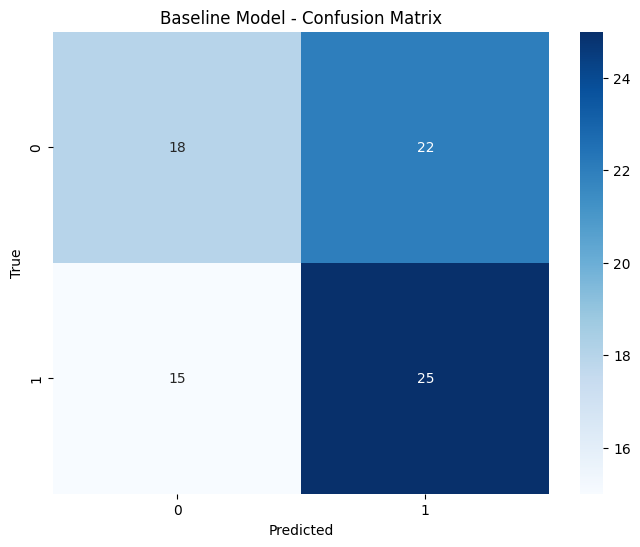


Baseline Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.45      0.49        40
         1.0       0.53      0.62      0.57        40

    accuracy                           0.54        80
   macro avg       0.54      0.54      0.53        80
weighted avg       0.54      0.54      0.53        80



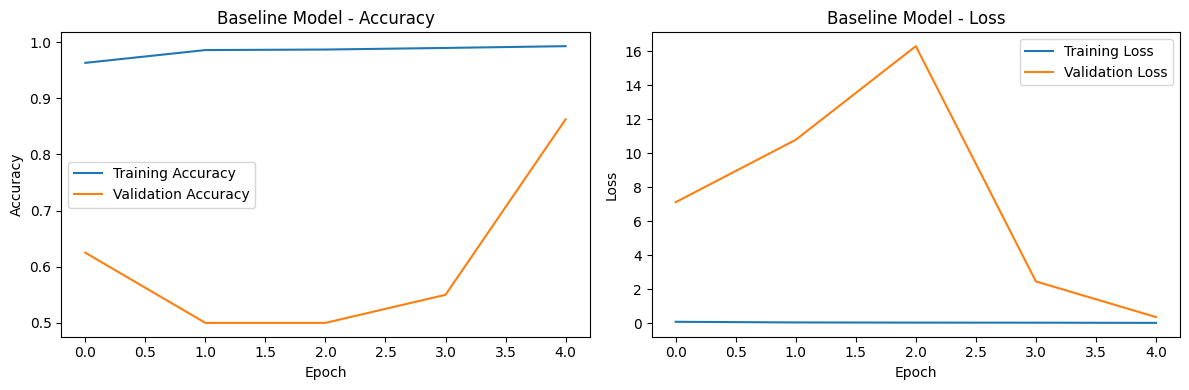


Evaluating Flicker Model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  


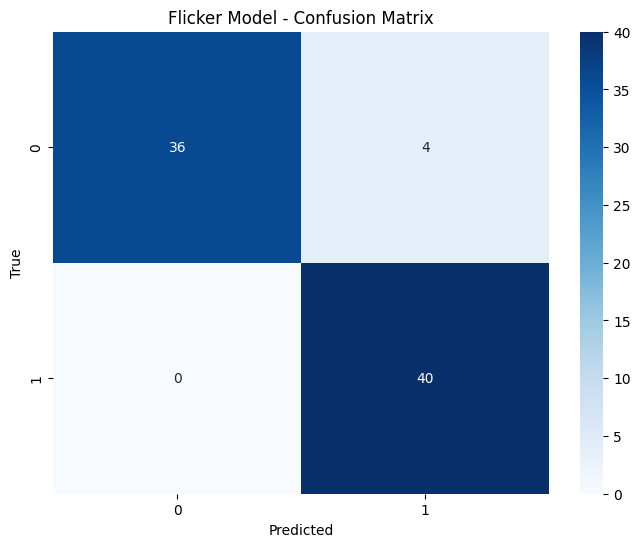


Flicker Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.91      1.00      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



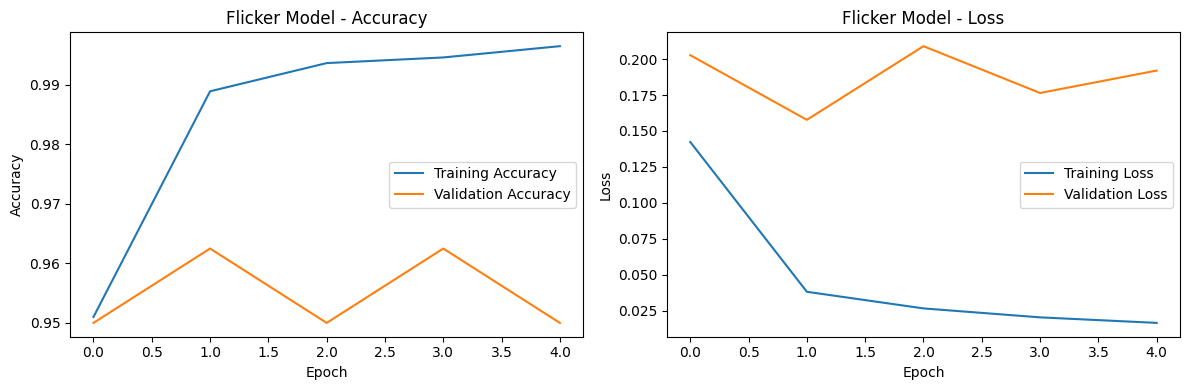


Model Comparison:
Baseline Model Validation Accuracy: 0.8625
Flicker Model Validation Accuracy: 0.9500


In [16]:
# Model Evaluation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_metrics(history, title):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, generator, title):
    """Evaluate model and plot confusion matrix"""
    # Get predictions
    y_pred = model.predict(generator)
    y_pred = (y_pred > 0.5).astype(int)
    
    # Get true labels
    y_true = []
    for i in range(len(generator)):
        _, labels = generator[i]
        y_true.extend(labels)
    y_true = np.array(y_true)
    
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(f"\n{title} Classification Report:")
    print(report)
    
    return y_true, y_pred

# Evaluate baseline model
print("Evaluating Baseline Model...")
baseline_true, baseline_pred = evaluate_model(baseline_model, baseline_val_gen, "Baseline Model")
plot_metrics(baseline_history, "Baseline Model")

# Evaluate flicker model
print("\nEvaluating Flicker Model...")
flicker_true, flicker_pred = evaluate_model(flicker_model, val_gen, "Flicker Model")
plot_metrics(flicker_history, "Flicker Model")

# Compare models
print("\nModel Comparison:")
print(f"Baseline Model Validation Accuracy: {baseline_history.history['val_accuracy'][-1]:.4f}")
print(f"Flicker Model Validation Accuracy: {flicker_history.history['val_accuracy'][-1]:.4f}")